In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import tensorflow as tf

import sys
sys.path.append('../')
from utils import *

2023-08-11 13:48:14.238315: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-11 13:48:14.836448: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
watches = pd.read_pickle('../../data/user-level-data')
videos = pd.read_pickle('../../data/videos_raw_metadata')

In [3]:
watches_df = dict()

def convert(watch):
    d = dict()
    d['playing'] = watch['playing']['id']
    suggested = []
    for s in watch['suggested']:
        if s != None:
            suggested.append(s['id'])
    d['suggested'] = suggested
    d['selected'] = watch['selected']
    return d

for user in watches:
    watches_df[user] = []
    for watch in watches[user]:
        if watch['playing'] == None:
            continue
        watch = convert(watch)
        watches_df[user].append(watch)

In [4]:
history = dict()
users = list(watches_df.keys())
data = dict()

for user in users:
    if len(watches_df[user]) < 10:
        continue
    history[user] = watches_df[user][:10]

    for watch in watches_df[user][10:]:
        if watch['selected'] != None:
            if user not in data:
                data[user] = []
            data[user].append(watch)

for user in list(history.keys()):
    if user not in data:
        history.pop(user)

In [6]:
for user in history:
    history[user] = [s['playing'] for s in history[user]]
    history[user] = [get_topic_vector(s) for s in history[user]]
    history[user] = np.array(history[user]).mean(axis=0)

In [5]:
from collections import Counter


all_topics = []
all_tags = []

for video in videos:
    video = videos[video]
    
    try:
        topics = video['topicDetails']['topicCategories']
        topics = [topic.split('/')[-1].lower() for topic in topics]
    except:
        topics = []

    all_topics += topics
    
    try:
        tags = video['snippet']['tags']
        tags = [tag.lower() for tag in tags]
    except:
        tags = []

    all_tags += tags

all_topics = list(set(all_topics))

atc = Counter(all_tags)
atc = pd.DataFrame.from_dict(atc, 'index', columns=['count'])
atc = atc.sort_values(['count'], ascending=False).head(5000)
all_tags = list(atc.index)

def get_one_hot_vector(topics, tags):
    oh_topics = np.zeros(len(all_topics))
    for topic in topics:
        oh_topics[all_topics.index(topic)] = 1
        
    oh_tags = np.zeros(len(all_tags))
    for tag in tags:
        if tag in all_tags:
            oh_tags[all_tags.index(tag)] = 1
        
    oh = np.concatenate([oh_topics , oh_tags])
    
    return oh


def get_topic_vector(video):
    video = videos[video]
    try:
        topics = video['topicDetails']['topicCategories']
        topics = [topic.split('/')[-1].lower() for topic in topics]
    except:
        topics = []

    try:
        tags = video['snippet']['tags']
        tags = [tag.lower() for tag in tags]
    except:
        tags = []

    return get_one_hot_vector(topics, tags)


In [7]:
# SG, P, SX, H = [], [], [], []
X = []
Y = []
topic_vectors = dict()

for user in tqdm(data):
    user_history = history[user]
    user_history = np.concatenate([user_history, [0]])
    for watch in data[user]:
        
        playing = watch['playing']
        selected = watch['selected']
        upnext = watch['suggested'][:15]

        if playing not in videos or selected not in videos or any([s not in videos for s in watch['suggested']]):
            continue
        if len(watch['suggested']) < 15:
            continue


        playing = get_topic_vector(watch['playing'])
        playing = np.concatenate([playing, [0]])

        suggesteds = []
        
        for i, s in enumerate(upnext):
            if s not in topic_vectors:
                topic_vectors[s] = get_topic_vector(s)
            sv = topic_vectors[s]
            sv = np.concatenate([sv, [0]])
            suggesteds.append(sv)
        
        suggesteds = np.array(suggesteds)
        suggesteds = np.mean(suggesteds, axis=0)

        for i, s in enumerate(upnext):
            selected = watch['selected']

            if s == selected:
                y = 0
            else:
                y = 0

            sv = topic_vectors[s]
            sv = np.concatenate([sv, [0]])

            x = np.vstack([sv, playing, suggesteds, user_history])

            # SG.append(suggesteds)
            # P.append(playing)
            # SX.append(sv)
            # H.append(user_history)
            X.append(x)
            Y.append(0)

        x = np.vstack([playing, playing, suggesteds, user_history])
        X.append(x)
        Y.append(1)
        # SG.append(suggesteds)
        # P.append(playing)
        # SX.append(playing)
        # H.append(user_history)
        # Y.append(1)
        

  0%|          | 0/1266 [00:00<?, ?it/s]

In [2]:
# [SG, P, SX, H, Y] = pkl.load(open('temp-SG_P_SX_H_Y.pkl', 'rb'))

In [12]:
SG = np.array(SG)
P = np.array(P)
SX = np.array(SX)
H = np.array(H)
Y = np.array(Y)

In [10]:
from sklearn.model_selection import train_test_split

# SG_train, SG_test, P_train, P_test, SX_train, SX_test, H_train, H_test,
# Y_train, Y_test = train_test_split(SG, P, SX, H, Y, test_size=0.2,
# random_state=42)


In [8]:
X = np.array(X)
Y = np.array(Y)

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [12]:
pos = Y.sum()
neg = len(Y) - pos
total = neg + pos
w0 = (1 / neg) * (total / 2.0)
w1 = (1 / pos) * (total / 2.0)
class_weights = {0:w0, 1:w1}
class_weights

{0: 0.5333333333333333, 1: 8.0}

In [13]:
pkl.dump([X, Y], open('temp-X_Y.pkl', 'wb'))

In [14]:
from tensorflow import keras
from keras import Model
from keras.models import Sequential
from keras.metrics import AUC, BinaryAccuracy
from keras.layers import Dense, Dropout, Flatten, Concatenate, Input
from tensorflow.keras.optimizers import SGD

In [15]:
X.shape

(250064, 4, 5063)

In [16]:
DP = 0.3

input_tensor = Input(shape=[4, 5063])

d = Dense(1025, activation='relu')(d)
d = Dropout(DP)(d)
d = Dense(512, activation='relu')(d)
d = Dropout(DP)(d)
d = Flatten()(d)
d = Dense(256, activation='relu')(d)
d = Dropout(DP)(d)
d = Dense(64, activation='relu')(d)
d = Dropout(DP)(d)

final = Dense(1, activation='sigmoid')(d)

METRICS = [BinaryAccuracy(name='accuracy'),
           AUC(name='auc'),       
           keras.metrics.AUC(name='prc', curve='PR')]

model = Model(inputs=input_tensor, outputs=final)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

2023-08-11 14:00:44.138969: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46692 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2023-08-11 14:00:44.139542: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46692 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:81:00.0, compute capability: 8.6


In [19]:
model.fit(X_train, Y_train,
            epochs=30,
            batch_size=64, 
            class_weight=class_weights, validation_split=0.2)

In [ ]:
DP = 0.3

suggested_tensor = Input(shape=[5063])
playing_tensor = Input(shape=[5063])
selected_tensor = Input(shape=[5063])
history_tensor = Input(shape=[5063])


sg_dense = Dense(256, activation='relu')(suggested_tensor)
# sg_dense = Dropout(DP)(sg_dense)
# sg_dense = Dense(256, activation='relu')(sg_dense)
# sg_dense = Dropout(DP)(sg_dense)
# sg_dense = Dense(64, activation='relu')(sg_dense)
sg_dense = Dropout(DP)(sg_dense)
sg = Flatten()(sg_dense)

pl_dense = Dense(256, activation='relu')(playing_tensor)
# pl_dense = Dropout(DP)(pl_dense)
# pl_dense = Dense(256, activation='relu')(pl_dense)
# pl_dense = Dropout(DP)(pl_dense)
# pl_dense = Dense(64, activation='relu')(pl_dense)
pl_dense = Dropout(DP)(pl_dense)
pl = Flatten()(pl_dense)

sl_dense = Dense(256, activation='relu')(selected_tensor)
# sl_dense = Dropout(DP)(sl_dense)
# sl_dense = Dense(256, activation='relu')(sl_dense)
# sl_dense = Dropout(DP)(sl_dense)
# sl_dense = Dense(64, activation='relu')(sl_dense)
sl_dense = Dropout(DP)(sl_dense)
sl = Flatten()(sl_dense)

hl_dense = Dense(256, activation='relu')(history_tensor)
hl_dense = Dropout(DP)(hl_dense)
hl_dense = Dense(256, activation='relu')(hl_dense)
# hl_dense = Dropout(DP)(hl_dense)
# hl_dense = Dense(64, activation='relu')(hl_dense)
hl_dense = Dropout(DP)(hl_dense)
hl = Flatten()(hl_dense)

merged = Concatenate()([sg, pl, sl, hl])
x = Dense(1025, activation='relu')(merged)
x = Dropout(DP)(x)
x = Dense(256, activation='relu')(merged)
x = Dropout(DP)(x)
x = Dense(64, activation='relu')(x)

final = Dense(1, activation='sigmoid')(x)


METRICS = [BinaryAccuracy(name='accuracy'),
           AUC(name='auc'),       
           keras.metrics.AUC(name='prc', curve='PR')]

model = Model(inputs=[suggested_tensor, playing_tensor, selected_tensor, history_tensor], outputs=final)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

2023-08-11 13:31:22.784281: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46692 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2023-08-11 13:31:22.785197: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46692 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:81:00.0, compute capability: 8.6


In [39]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 4, 5063)]         0         
                                                                 
 dense_24 (Dense)            (None, 4, 2056)           10411584  
                                                                 
 dropout_20 (Dropout)        (None, 4, 2056)           0         
                                                                 
 dense_25 (Dense)            (None, 4, 1025)           2108425   
                                                                 
 dropout_21 (Dropout)        (None, 4, 1025)           0         
                                                                 
 dense_26 (Dense)            (None, 4, 512)            525312    
                                                                 
 dropout_22 (Dropout)        (None, 4, 512)            0   

In [40]:
model.fit([SG_train, P_train, SX_train, H_train], Y_train,
            epochs=30,
            batch_size=64, 
            class_weight=class_weights, validation_split=0.2)

2023-08-11 13:43:36.466446: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.02GiB (rounded to 3241130240)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-08-11 13:43:36.466529: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-08-11 13:43:36.466551: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 98, Chunks in use: 98. 24.5KiB allocated for chunks. 24.5KiB in use in bin. 3.4KiB client-requested in use in bin.
2023-08-11 13:43:36.466568: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2023-08-11 13:43:36.466579: I tensorflow/tsl/framework/bfc_allocato

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

e at 7fa08fb73a00 of size 4352 next 82
2023-08-11 13:43:36.467104: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7fa08fb74b00 of size 1024 next 84
2023-08-11 13:43:36.467111: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7fa08fb74f00 of size 1024 next 85
2023-08-11 13:43:36.467116: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7fa08fb75300 of size 1024 next 88
2023-08-11 13:43:36.467122: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7fa08fb75700 of size 1024 next 89
2023-08-11 13:43:36.467127: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7fa08fb75b00 of size 1024 next 92
2023-08-11 13:43:36.467133: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7fa08fb75f00 of size 1024 next 93
2023-08-11 13:43:36.467138: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7fa08fb76300 of size 1024 next 95
2023-08-11 13:43:36.467144: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7fa08fb76700 of size 1024 n

In [22]:
#f1 score
from sklearn.metrics import classification_report

y_pred_keras = model.predict([SG_test, P_test, SX_test, H_test]).ravel()
y_pred = np.round(y_pred_keras)
print(classification_report(Y_test, y_pred))

1563/1563 [==============================] - 4s 2ms/step
              precision    recall  f1-score   support

           0       1.00      0.93      0.97     46927
           1       0.50      1.00      0.66      3086

    accuracy                           0.94     50013
   macro avg       0.75      0.97      0.81     50013
weighted avg       0.97      0.94      0.95     50013



1563/1563 [==============================] - 4s 2ms/step


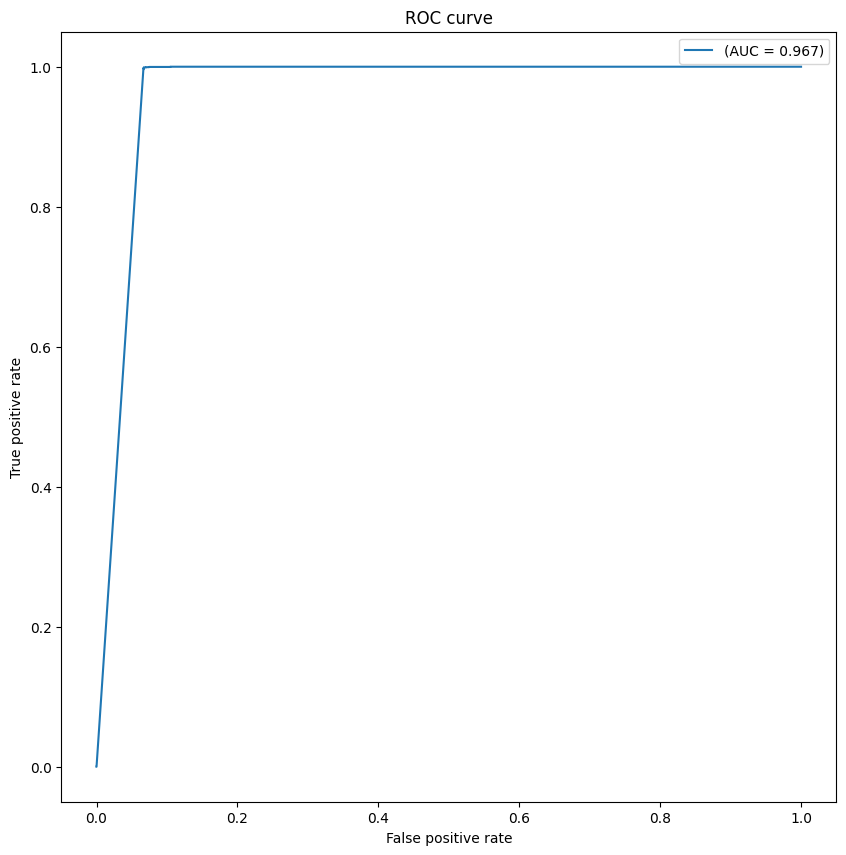

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_pred_keras = model.predict([SG_test, P_test, SX_test, H_test]).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(figsize=(10,10))
plt.plot(fpr_keras, tpr_keras, label='(AUC = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
